In [291]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

code_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "code"))
sys.path.append(code_dir)

from anonymization.utils import compute_block_probability_matrix, generate_anonymized_graph

In [292]:
n = 100
K = 15
seed = 2025
dataset = "ca-hepth"
algorithm = "merge"  # Should match folder naming and generation
filename_suffix = f"n{n}_K{K}_seed{seed}"

In [293]:
results_dir = f"../data/results/real/{dataset}/{algorithm}"
plot_dir = f"{results_dir}/plots"
os.makedirs(plot_dir, exist_ok=True)

In [294]:
A_original = np.load(f"../data/real/{dataset}/adjacency_A_{dataset}_n{n}_seed{seed}.npy")
z = np.load(f"{results_dir}/z_anonymized_{algorithm}_{filename_suffix}.npy")
block_sizes = np.load(f"{results_dir}/final_block_sizes_{filename_suffix}.npy")
log_likelihood = np.load(f"{results_dir}/log_likelihood_trace_{n}_K{K}.npy")
with open(f"{results_dir}/total_merge_steps_{n}_K{K}.txt", "r") as f:
    total_steps = int(f.read())

In [295]:
G_original = nx.from_numpy_array(A_original)
layout = nx.spring_layout(G_original, seed=seed)

In [296]:
B, _ = compute_block_probability_matrix(A_original, z)
adj_path = f"{results_dir}/adj_matrix_{filename_suffix}.npy"
if not os.path.exists(adj_path):
    print("Generating anonymized adjacency matrix A_hat using SBM sampling...")
    A_hat = generate_anonymized_graph(z, B, seed=seed)
    np.save(adj_path, A_hat)
else:
    A_hat = np.load(adj_path)

G_anonymized = nx.from_numpy_array(A_hat)

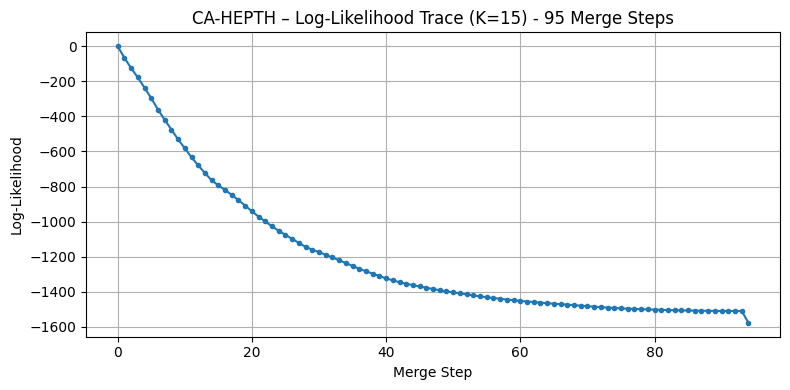

In [297]:
# --- Plot 1: Log-Likelihood Trace ---
plt.figure(figsize=(8, 4))
plt.plot(log_likelihood, marker="o", markersize=3)
plt.title(f"{dataset.upper()} – Log-Likelihood Trace (K={K}) - {total_steps} Merge Steps")
plt.xlabel("Merge Step")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{plot_dir}/log_likelihood_trace_{filename_suffix}.png", dpi=500, bbox_inches="tight")
plt.show()

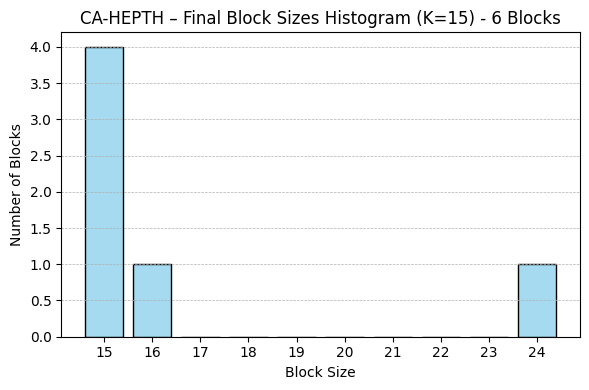

In [298]:
# --- Plot 2: Final Block Sizes Histogram ---
plt.figure(figsize=(6, 4))
sns.histplot(
    block_sizes,
    bins=range(min(block_sizes), max(block_sizes) + 2),
    discrete=True,
    shrink=0.8,
    color="skyblue",
    edgecolor="black",
)
plt.title(f"{dataset.upper()} – Final Block Sizes Histogram (K={K}) - {len(block_sizes)} Blocks")
plt.xlabel("Block Size")
plt.ylabel("Number of Blocks")
plt.xticks(range(min(block_sizes), max(block_sizes) + 1))
plt.grid(True, axis="y", linestyle="--", linewidth=0.5)
plt.tight_layout()
plt.savefig(f"{plot_dir}/final_block_sizes_{filename_suffix}.png", dpi=500, bbox_inches="tight")
plt.show()

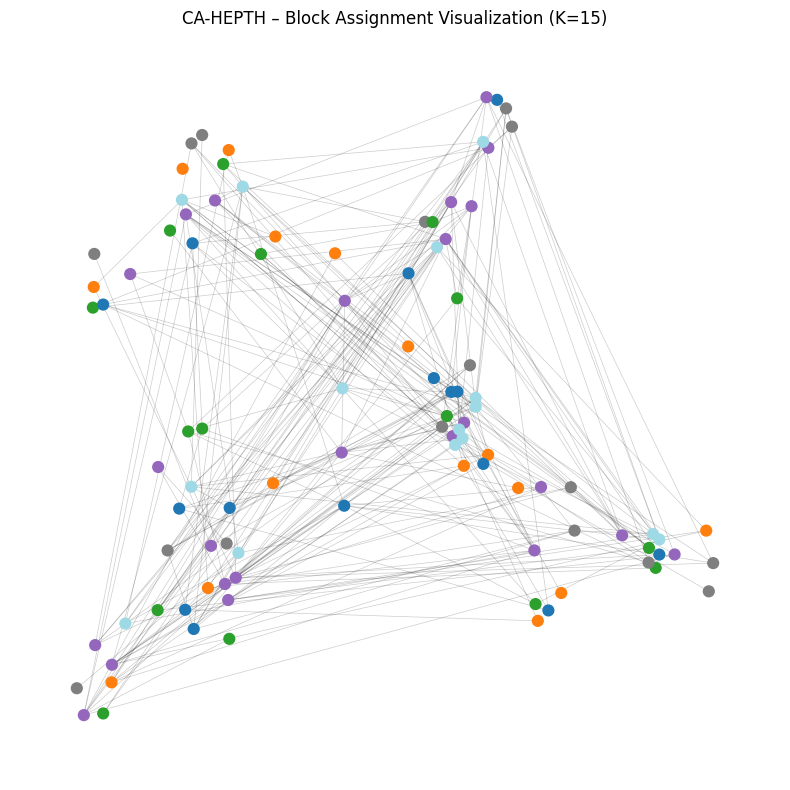

In [299]:
# --- Plot 3: Block Assignment Visualization using same layout ---
plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G_anonymized, pos=layout, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(
    G_anonymized,
    pos=layout,
    node_color=z,
    cmap=plt.cm.tab20,
    node_size=60,
)
plt.title(f"{dataset.upper()} – Block Assignment Visualization (K={K})")
plt.axis("off")
plt.tight_layout()
plt.savefig(f"{plot_dir}/graph_structure_{filename_suffix}.png", dpi=500, bbox_inches="tight")
plt.show()

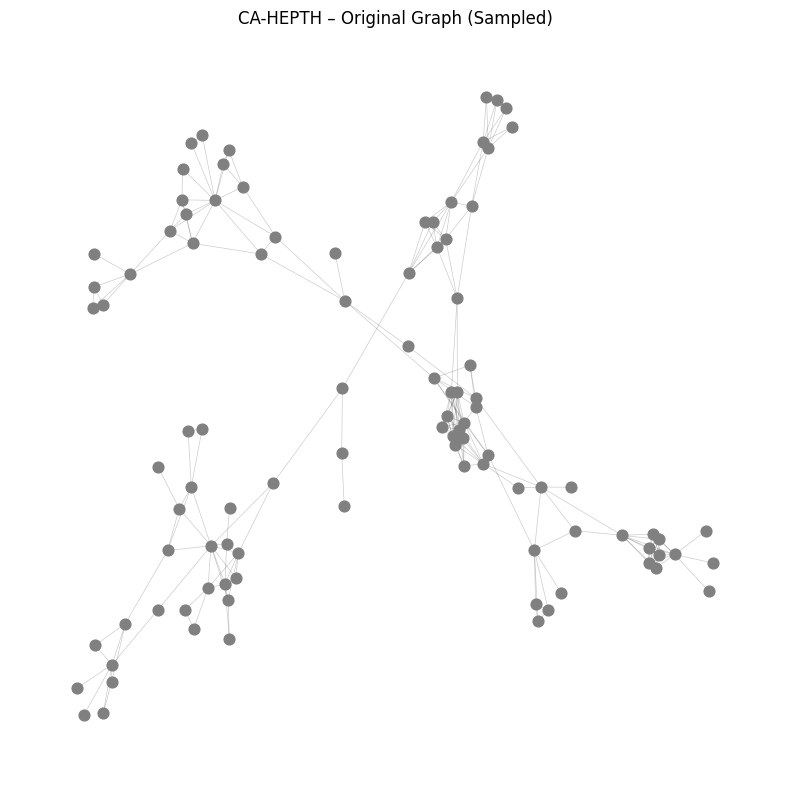

In [300]:
# Compare with original graph visually
plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G_original, pos=layout, alpha=0.2, width=0.5)
nx.draw_networkx_nodes(
    G_original,
    pos=layout,
    node_color="gray",
    node_size=60,
)
plt.title(f"{dataset.upper()} – Original Graph (Sampled)")
plt.axis("off")
plt.tight_layout()
plt.savefig(f"{plot_dir}/graph_structure_original_{filename_suffix}.png", dpi=500, bbox_inches="tight")
plt.show()